In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from joblib import Parallel, delayed

import glob, sys, os
import datetime
from scipy import stats
import multiprocessing

from config import config

sys.path.append(os.path.join(os.getcwd(), "trackintel"))
from trackintel.analysis.tracking_quality import temporal_tracking_quality


import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 300
%matplotlib inline
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13

np.set_printoptions(precision=4, suppress= True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def get_stps():
    stps = pd.read_csv(os.path.join(config['S_proc'], 'stps_act_user_50.csv'))
    
    stps.rename(columns={"user_id": "userid", "started_at": "startt", "finished_at": "endt"},inplace=True)

    stps['startt'] = pd.to_datetime(stps['startt']).dt.tz_localize(None)
    stps['endt'] = pd.to_datetime(stps['endt']).dt.tz_localize(None)
    return stps

def get_trips():
    trips = pd.read_csv(os.path.join(config['S_proc'], 'trips.csv'))

    trips.rename(columns={"user_id": "userid", "started_at": "startt", "finished_at": "endt"}, inplace=True)

    trips['startt'] = pd.to_datetime(trips['startt']).dt.tz_localize(None)
    trips['endt'] = pd.to_datetime(trips['endt']).dt.tz_localize(None)
    return trips

def _preprocess(df):
    df.rename(
        columns={"userid": "user_id", "startt": "started_at", "endt": "finished_at", "dur_s": "duration"}, inplace=True
    )
    return df

def _get_all_trace(stps, trips):

    stps = _preprocess(stps)
    trips = _preprocess(trips)
    print("User number:", len(stps["user_id"].unique()), len(trips["user_id"].unique()))

    # merge trips and staypoints
    print("starting merge", stps.shape, trips.shape)
    stps["type"] = "stp"
    trips["type"] = "trip"
    df_all = pd.merge(stps, trips, how="outer")
    print("finished merge", df_all.shape)
    print("*"*50)

    return df_all

stps = get_stps()
trips = get_trips()
all_trace = _get_all_trace(stps, trips)

print(len(stps['user_id'].unique()), len(trips['user_id'].unique()), len(all_trace['user_id'].unique()))

User number: 139 139
starting merge (259887, 12) (245689, 9)
finished merge (505576, 17)
**************************************************
139 139 139


# Determine the user filter
## Overall

In [36]:
# get the total quality and tracked days
total_quality = temporal_tracking_quality(all_trace, granularity="all")
total_quality['days'] = all_trace.groupby("user_id").apply(lambda x: (x['finished_at'].max() - x['started_at'].min()).days).values

total_quality.sort_values(by='quality', ascending=False, inplace=True)

# select total quality and tracked days
selected = total_quality.loc[(total_quality['days']>300) & (total_quality['quality']>0.7)].reset_index(drop=True)
# save
selected.to_csv(os.path.join(config["results"], "SBB_user_filtered.csv"), index=False)

print(selected)

     user_id   quality  days
0       1617  0.992109   430
1       1602  0.987011   434
2       1721  0.986556   421
3       1673  0.986205   415
4       1716  0.985793   421
..       ...       ...   ...
111     1802  0.720105   406
112     1628  0.717939   415
113     1609  0.716239   421
114     1601  0.716053   342
115     1760  0.701097   415

[116 rows x 3 columns]


## Sliding window

In [39]:
def filter_user(df):
    consider = df.loc[df['quality']!=0]
    if consider['quality'].min() > 0.6:
        return df

def getTrackingQuality(df, window_size):

    weeks = (df['finished_at'].max() - df['started_at'].min()).days // 7
    start_date = df['started_at'].min().date()

    quality_list = []
    # construct the sliding week gdf
    for i in range(0, weeks-window_size):
        curr_start = datetime.datetime.combine(start_date + datetime.timedelta(weeks=i), datetime.time())
        curr_end  = datetime.datetime.combine(curr_start + datetime.timedelta(weeks=window_size), datetime.time())

        # the total df for this time window
        cAll_gdf = df.loc[(df['started_at'] >= curr_start) & (df['finished_at'] < curr_end)]
        if cAll_gdf.shape[0] == 0:
            continue
        total_sec = (curr_end-curr_start).total_seconds()

        quality_list.append([i, cAll_gdf['duration'].sum()/total_sec])
    ret = pd.DataFrame(quality_list, columns=['timestep','quality'])
    ret["user_id"] = df["user_id"].unique()[0]
    return ret

sliding = all_trace.groupby("user_id").apply(getTrackingQuality, window_size=10).reset_index(drop=True)

# use selected as a filter 
sliding = sliding.loc[sliding['user_id'].isin(selected['user_id'].unique())]


slide_user = sliding.groupby("user_id").apply(filter_user).reset_index(drop=True).dropna()
slide_user = slide_user.groupby("user_id", as_index=False)["quality"].mean()

# save
slide_user.to_csv(os.path.join(config["results"], "SBB_user_window_filtered.csv"), index=False)

print(slide_user)

    user_id   quality
0    1596.0  0.973634
1    1597.0  0.966084
2    1602.0  0.978700
3    1605.0  0.922213
4    1606.0  0.959640
..      ...       ...
88   1805.0  0.777991
89   1810.0  0.872272
90   1812.0  0.958226
91   1848.0  0.954729
92   1934.0  0.870983

[93 rows x 2 columns]


# Determine the time window
We choose 5 or 10? as the time window. normalize by the tracking quality.

In [4]:
# get locations within the activity set
def _get_act_locs(df, time_window=5, filter_len=10):
    if df.shape[0] >= 2:
        avg_duration_min = df['duration'].sum() / 60 / time_window
        if avg_duration_min < filter_len:
            len_class = 0
        elif avg_duration_min < 30:
            len_class = 1
        elif avg_duration_min < 60:
            len_class = 2
        elif avg_duration_min < 60 * 6:
            len_class = 3
        elif avg_duration_min < 60 * 12:
            len_class = 4
        elif avg_duration_min < 60 * 24:
            len_class = 5
        elif avg_duration_min < 60 * 48:
            len_class = 6
        else:
            len_class = 7
        return pd.Series([avg_duration_min, len_class], index=['duration','class'])

def applyParallel(dfGrouped, func, time_window):
    # multiprocessing.cpu_count()
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group, time_window) for name, group in dfGrouped)
    return pd.concat(retLst)

def getLocSize(df, time_window):
    weeks = (df['started_at'].max() - df['started_at'].min()).days // 7
    start_date = df['started_at'].min().date()
    
    res = []
    for i in range(0, weeks-time_window+1):
        curr_start = datetime.datetime.combine(start_date + datetime.timedelta(weeks=i), datetime.time())
        curr_end  = datetime.datetime.combine(curr_start + datetime.timedelta(weeks=time_window), datetime.time())
        
        curr = df.loc[(df['started_at'] >= curr_start) & (df['finished_at'] <  curr_end)]

#         loc
        curr_stps = curr.loc[curr['type']=='stp']
        curr_ASet = curr_stps.groupby('locid', as_index=False).apply(_get_act_locs, time_window=time_window).dropna()
        if curr_ASet.empty:
            continue
        curr_ASet = curr_ASet.loc[curr_ASet['class']>0]
        loc_capa = len(curr_ASet)

#         quality
        curr_quality = curr['duration'].sum()/(curr_end-curr_start).total_seconds()
        if curr_quality > 1:
            curr_quality = 1
            
#         get the results
        if curr_quality == 0:
            res.append([i, loc_capa, 0])
        else:
            res.append([i, loc_capa, loc_capa/curr_quality])
    
    res = pd.DataFrame(res, columns=['timeStep','loc','loc_norm'])
    res['user_id'] = df['user_id'].unique()[0]
    return res

# files = glob.glob(os.path.join(config["S_act"], "*_aSet.csv"))
time_window_ls = [4, 5, 6, 8, 10, 15, 20]

prop = 0.8
selected_user = pd.read_csv(os.path.join(config["results"], "SBB_user_window_filtered.csv"))["user_id"].unique()
print(selected_user.shape)

# user filter
selected_all_trace = all_trace.loc[all_trace['user_id'].isin(selected_user)]

for time_window in time_window_ls:
    
    activity_set = applyParallel(selected_all_trace.groupby("user_id"), getLocSize, time_window)
    
    # filter by timestep
    temp = activity_set.groupby(["user_id","timeStep"], as_index=False).size()
    user_count = temp.groupby("timeStep").size()
    valid_timestep = (user_count.loc[user_count>=user_count.max()*prop].index).to_numpy()
    activity_set = activity_set[activity_set['timeStep'].isin(valid_timestep)].reset_index(drop=True)

    activity_set['timeStep'] = activity_set['timeStep'].astype(int)
    activity_set['loc'] = activity_set['loc'].astype(int)
    activity_set['loc_norm'] = activity_set['loc_norm'].astype(int)

    print(time_window)
    # simple linear regression for stability
    slope, intercept, rvalue, p_value, std_err = stats.linregress(activity_set['timeStep'],activity_set['loc'])
    print("{:.3f} {:.3f} {:.2f} {:.2f} {}".format(slope, std_err, intercept, p_value, p_value>0.05))
    slope, intercept, rvalue, p_value, std_err = stats.linregress(activity_set['timeStep'],activity_set['loc_norm'])
    print("{:.3f} {:.3f} {:.2f} {:.2f} {}".format(slope, std_err, intercept, p_value, p_value>0.05))

    print("*"*50)

    # print(slope, intercept, rvalue, p_value, std_err)


(93,)
4
-0.017 0.004 11.63 0.00 False
-0.014 0.004 12.24 0.00 False
**************************************************
5
-0.019 0.004 13.30 0.00 False
-0.015 0.004 13.98 0.00 False
**************************************************
6
-0.023 0.004 14.87 0.00 False
-0.017 0.005 15.62 0.00 False
**************************************************
8
-0.029 0.005 17.56 0.00 False
-0.022 0.006 18.42 0.00 False
**************************************************
10
-0.027 0.006 19.56 0.00 False
-0.018 0.007 20.50 0.01 False
**************************************************
15
-0.015 0.009 22.99 0.08 True
-0.002 0.009 24.10 0.80 True
**************************************************
20
-0.004 0.011 25.30 0.71 True
0.012 0.012 26.56 0.33 True
**************************************************


### Activity set plot

In [42]:
prop = 0.8
activity_set = applyParallel(selected_all_trace.groupby("user_id"), getLocSize, time_window = 5)

# filter by timestep
temp = activity_set.groupby(["user_id","timeStep"], as_index=False).size()
user_count = temp.groupby("timeStep").size()
valid_timestep = (user_count.loc[user_count>=user_count.max()*prop].index).to_numpy()
activity_set = activity_set[activity_set['timeStep'].isin(valid_timestep)].reset_index(drop=True)

activity_set['timeStep'] = activity_set['timeStep'].astype(int)
activity_set['loc'] = activity_set['loc'].astype(int)
activity_set['loc_norm'] = activity_set['loc_norm'].astype(int)


activity_set['timeStep'] = activity_set['timeStep'] + 5

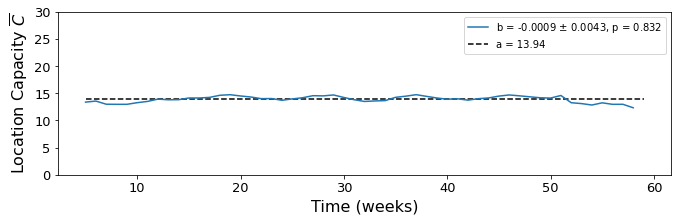

In [47]:
plot_actSet = activity_set.groupby('timeStep', as_index=False).mean()

slope, intercept, rvalue, p_value, std_err = stats.linregress(activity_set['timeStep'],activity_set['loc_norm'])
plt.figure(figsize=(11,3))
plt.plot(plot_actSet['timeStep'], plot_actSet['loc_norm'], label=f'b = {slope:.4f} $\pm$ {std_err:.4f}, p = {p_value:.3f}')

plt.hlines(intercept, 5, 59, 'black',linestyles='dashed',alpha=1, label=f"a = {intercept:.2f}")

plt.ylabel("Location Capacity $\overline{C}$",fontsize = 16)
plt.xlabel("Time (weeks)",fontsize = 16)
plt.legend(prop={'size': 12})

plt.ylim([0, 30])
plt.legend()
plt.show()

### Trip set stability

In [7]:
def get_curr_trips(t, stps, ASet):
    # get the locations in activity set
    valid_stps = stps.loc[stps['locid'].isin(ASet['locid'].unique())]
    
    # consider trip that ends in valid stps
    valid_t = t.loc[t['nstpid'].isin(valid_stps['id'])]
    valid_t = valid_t[['id','length_m','duration','nstpid']]
    
    # enrich with loc id
    valid_t = valid_t.merge(valid_stps[['id','locid']], left_on='nstpid', right_on='id')
    
    valid_t.drop(columns ={"id_y", "nstpid"}, inplace = True)
    
    # enrich with activity set class
    valid_t = valid_t.merge(ASet[['locid', 'class']], on='locid', how='left')
    
    valid_t.rename(columns={'locid':'nloc', 'id_x':'tripid'}, inplace=True)

    return valid_t

def getTripSize(df, time_window):
    weeks = (df['started_at'].max() - df['started_at'].min()).days // 7
    start_date = df['started_at'].min().date()
    
    res = []
    for i in range(0, weeks-time_window+1):
        curr_start = datetime.datetime.combine(start_date + datetime.timedelta(weeks=i), datetime.time())
        curr_end  = datetime.datetime.combine(curr_start + datetime.timedelta(weeks=time_window), datetime.time())
        
        curr = df.loc[(df['started_at'] >= curr_start) & (df['finished_at'] <  curr_end)]
#         get activity set
        curr_stps = curr.loc[curr['type'] == 'stp']
        curr_ASet = curr_stps.groupby('locid', as_index=False).apply(_get_act_locs, time_window=time_window).dropna()
        if curr_ASet.empty:
            continue
        curr_ASet = curr_ASet.loc[curr_ASet['class']>0]
        
#         get activity set
        curr_t = curr.loc[curr['type'] == 'trip']
        curr_tSet = get_curr_trips(curr_t, curr_stps, curr_ASet)
        
#         quality
        curr_quality = curr['duration'].sum()/(curr_end-curr_start).total_seconds()
        
        if curr_quality > 1:
            curr_quality = 1
        
        trip_capa = len(curr_tSet)/time_window
#         get the results
        if curr_quality == 0:
            res.append([i, trip_capa, 0])
        else:
            res.append([i, trip_capa, trip_capa/curr_quality])

    
    res = pd.DataFrame(res, columns=['timeStep','trip','trip_norm'])
    res['user_id'] = df['user_id'].unique()[0]
    return res

time_window_ls = [4, 5, 6, 8, 10, 15, 20, 30, 40]

prop = 0.8
selected_user = pd.read_csv(os.path.join(config["results"], "SBB_user_window_filtered.csv"))["user_id"].unique()
print(selected_user.shape)

# user filter
selected_all_trace = all_trace.loc[all_trace['user_id'].isin(selected_user)]
print(selected_all_trace["user_id"].unique().shape)

for time_window in time_window_ls:
    trip_set = applyParallel(selected_all_trace.groupby("user_id"), getTripSize, time_window = time_window)
    # filter by timestep
    temp = trip_set.groupby(["user_id","timeStep"], as_index=False).size()
    user_count = temp.groupby("timeStep").size()
    valid_timestep = (user_count.loc[user_count>=user_count.max()*prop].index).to_numpy()
    trip_set = trip_set[trip_set['timeStep'].isin(valid_timestep)].reset_index(drop=True)

    trip_set['timeStep'] = trip_set['timeStep'].astype(int)
    trip_set['trip'] = trip_set['trip'].astype(int)
    trip_set['trip_norm'] = trip_set['trip_norm'].astype(int)

    trip_set['timeStep'] = trip_set['timeStep'] + 5
    
    print(time_window)
    slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip'])
    print("{:.3f} {:.3f} {:.2f} {:.2f} {}".format(slope, std_err, intercept, p_value, p_value>0.05))
    slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip_norm'])
    print("{:.3f} {:.3f} {:.2f} {:.2f} {}".format(slope, std_err, intercept, p_value, p_value>0.05))
    print("*"*50)

(93,)
(93,)
4
-0.010 0.007 21.39 0.13 True
-0.002 0.007 23.14 0.78 True
**************************************************
5
-0.010 0.006 21.48 0.10 True
-0.001 0.007 23.13 0.86 True
**************************************************
6
-0.012 0.006 21.57 0.05 True
-0.002 0.007 23.16 0.81 True
**************************************************
8
-0.017 0.007 21.70 0.01 False
-0.007 0.007 23.24 0.33 True
**************************************************
10
-0.020 0.007 21.69 0.00 False
-0.009 0.007 23.17 0.23 True
**************************************************
15
-0.024 0.008 21.51 0.00 False
-0.011 0.008 22.92 0.16 True
**************************************************
20
-0.025 0.009 21.24 0.00 False
-0.012 0.009 22.62 0.20 True
**************************************************
30
-0.017 0.013 20.64 0.19 True
-0.006 0.014 22.09 0.66 True
**************************************************
40
0.010 0.024 20.02 0.66 True
0.015 0.025 21.58 0.56 True
*********************************

### Trip set plot

In [68]:
trip_set = applyParallel(selected_all_trace.groupby("user_id"), getTripSize, time_window = 5)
# filter by timestep
temp = trip_set.groupby(["user_id","timeStep"], as_index=False).size()
user_count = temp.groupby("timeStep").size()
valid_timestep = (user_count.loc[user_count>=user_count.max()*prop].index).to_numpy()
trip_set = trip_set[trip_set['timeStep'].isin(valid_timestep)].reset_index(drop=True)

trip_set['timeStep'] = trip_set['timeStep'].astype(int)
trip_set['trip'] = trip_set['trip'].astype(int)
trip_set['trip_norm'] = trip_set['trip_norm'].astype(int)

trip_set['timeStep'] = trip_set['timeStep'] + 5

slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip'])
print("{:.3f} {:.3f} {:.2f} {:.2f} {}".format(slope, std_err, intercept, p_value, p_value>0.05))
slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip_norm'])
print("{:.3f} {:.3f} {:.2f} {:.2f} {}".format(slope, std_err, intercept, p_value, p_value>0.05))

-0.010 0.006 21.48 0.10 True
-0.001 0.007 23.13 0.86 True


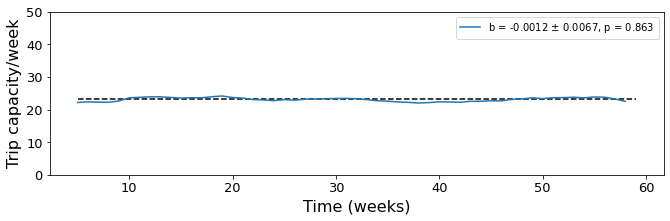

In [77]:
plot_tripSet = trip_set.groupby('timeStep', as_index=False).mean()

slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip_norm'])
plt.figure(figsize=(11,3))
plt.plot(plot_tripSet['timeStep'], plot_tripSet['trip_norm'], label=f'b = {slope:.4f} $\pm$ {std_err:.4f}, p = {p_value:.3f}')

plt.hlines(intercept, 5, 59, 'black',linestyles='dashed',alpha=1)

plt.ylabel("Trip capacity/week",fontsize = 16)
plt.xlabel("Time (weeks)",fontsize = 16)
plt.legend(prop={'size': 12})

plt.ylim([0, 50])
plt.legend()
plt.savefig(r'C:\Work\Projects\GIScience\data\Figure\trip_stability.png', bbox_inches='tight', dpi=600)
plt.show()

## Net gain

In [31]:
from tqdm import tqdm

def get_curr_trips(t, stps, ASet):
    # get the locations in activity set
    valid_stps = stps.loc[stps['locid'].isin(ASet['locid'].unique())]
    
    # consider trip that ends in valid stps
    valid_t = t.loc[t['nstpid'].isin(valid_stps['id'])]
    valid_t = valid_t[['id','length_m','duration','nstpid']]
    
    # enrich with loc id
    valid_t = valid_t.merge(valid_stps[['id','locid']], left_on='nstpid', right_on='id')
    
    valid_t.drop(columns ={"id_y", "nstpid"}, inplace = True)
    
    # enrich with activity set class
    valid_t = valid_t.merge(ASet[['locid', 'class']], on='locid', how='left')
    
    valid_t.rename(columns={'locid':'nloc', 'id_x':'tripid'}, inplace=True)

    return valid_t

def applyParallel(dfGrouped, func, time_window):
    # multiprocessing.cpu_count()
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group, time_window) for name, group in dfGrouped)
    return pd.concat(retLst)

def getTripSet(df, time_window):
    weeks = (df['started_at'].max() - df['started_at'].min()).days // 7
    start_date = df['started_at'].min().date()
    
    res = []
    for i in range(0, weeks-time_window+1):
        curr_start = datetime.datetime.combine(start_date + datetime.timedelta(weeks=i), datetime.time())
        curr_end  = datetime.datetime.combine(curr_start + datetime.timedelta(weeks=time_window), datetime.time())
        
        curr = df.loc[(df['started_at'] >= curr_start) & (df['finished_at'] <  curr_end)]
#         get activity set
        curr_stps = curr.loc[curr['type'] == 'stp']
        curr_ASet = curr_stps.groupby('locid', as_index=False).apply(_get_act_locs, time_window=time_window).dropna()
        if curr_ASet.empty:
            continue
        curr_ASet = curr_ASet.loc[curr_ASet['class']>0]
        
#         get trip set
        curr_t = curr.loc[curr['type'] == 'trip']
        curr_tSet = get_curr_trips(curr_t, curr_stps, curr_ASet)
        
        curr_tSet["timeStep"] = i
        
#         get the results
        res.append(curr_tSet[["tripid", "timeStep"]])

    res = pd.concat(res)
    res['user_id'] = df['user_id'].unique()[0]
    return res

time_window = 10

prop = 0.8
selected_user = pd.read_csv(os.path.join(config["results"], "SBB_user_window_filtered.csv"))["user_id"].unique()
print(selected_user.shape)

# user filter
selected_all_trace = all_trace.loc[all_trace['user_id'].isin(selected_user)]
print(selected_all_trace["user_id"].unique().shape)

trip_set = applyParallel(selected_all_trace.groupby("user_id"), getTripSet, time_window = time_window)

(93,)
(93,)


In [32]:
def net_gain_individual(df):
#     print(df)
    set_ls = df.groupby('timeStep')['tripid'].apply(lambda x: set(x)).to_list()
    
    gain_ls = []
    for i in range(len(set_ls)-1):
        add = len(set_ls[i+1] - set_ls[i])
        remove = len(set_ls[i] - set_ls[i+1])
        
        gain_ls.append((add - remove))
    mean = np.mean(gain_ls)
    std = np.std(gain_ls)
    
    stable = np.abs(mean)/std <1
    return stable

stable_num = trip_set.groupby("user_id").apply(net_gain_individual)
print(stable_num.sum()/stable_num.shape[0] * 100)

100.0
